# Project: Stochastic Gradient Hamiltonian Monte Carlo

In this project we are going to implement standard HMC, HMC with MH, Naive SGHMC and SGHMC with Friction.

# standard HMC

### Basic settings

Suppose we want to sample from the posterior distribution: 
$$p(\theta|D) \propto exp(-U(\theta))$$ where $D = \{x_{1\:n}\}$
which are independent and $U$ is the potential energy fucntion: 
$$U = -\sum_{x_i \in D}\log p(x|\theta)- \log p(\theta)$$
We will sample from joint distribution $$\pi(\theta, r) \propto exp(-U(\theta)-\frac{1}{2}r^TM^{-1}r)$$
where r is the auxiliary momentum variables and M is the mass matrix. They define the kinetic energy together.
Then we discard r and keep $\theta$.

The Hamiltonian function is:
$$H(\theta, r)=U(\theta)+\frac{1}{2}r^TM^{-1}r$$
The Hamiltonian dynamics are:
$$d\theta = M^{-1}r dt\\ dr=-\triangledown U(\theta) dt$$

### Implement HMC

We use a univariate $\theta$ for illustration. Suppose $U(\theta)=-2\theta^2+\theta^4$. Based on $U(\theta)$, we need to define functions $\triangledown U, H$.

# Stochastic Gradient HMC with Naive Approach

The Naive approach refers to the simple plug-in estimator of $\triangledown \tilde{U}(\theta) = -\frac{|D|}{|\tilde{D}|}\sum_{x \in \tilde{D}} \triangledown log p(x|\theta) - \triangledown log p(\theta)$ with minibatch $\tilde{D}$. $\triangledown \tilde{U}(\theta)$ is computationally easier, but then the resulting joint distribution $\pi(\theta, r)$ is not invariant.

The Hamiltonian Dynamics are:
$$d\theta = M^{-1}r dt\\ dr=-\triangledown U(\theta) dt + N(0,2B(\theta)) dt$$
where $B(\theta) = \frac{1}{2}\epsilon V(\theta)$

# need to find covariance of the stochastic gradient noise

Since $\epsilon$ is small, it does not really matter that V is. Thus we take V as identity.

### Implement Naive SGHMC

# SGHMC with Friction

Add friction term to momentum update:
$$
d\theta = M^{-1}r dt\\
dr = - \triangledown U(\theta)dt - BM^{-1}rdt+N(0,2Bdt)
$$

# new proposal for SGHMC with friction

In [1]:
import scipy.stats as sta
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from numba import jit,njit
from ipyparallel import Client
import random
import numpy

## First Attempt: Basic Code

In [2]:
def SGHMC_friction(theta0, X, gradU, eps, sample_size, B, C, batch_size,burnin, M = None):
    '''
    SGHMC with friction. See details from Stochastic Gradient Hamiltonian Monte Carlo (Chen et al., 2014)
    
    INPUT:
    ----------------------------------------------------------------------
    theta0(numpy array of shape(p,)): starting position of theta
    
    X(numpy array of shape(n,m)): data
    
    grad_logden_data: gradient of the data log density
    
    grad_logden_prior: gradient of the prior log density
    
    eps: step size
    
    sample_size: number of samples drawn from prosterior distribution
    
    B: noise estimate
    
    C: user specified friction term
    
    batch_size: size of minibatches
    
    burnin: number of iterations for warm up
    
    M(optional): Mass matrix, defualt is set to be identity.
    ----------------------------------------------------------------------
    OUTPUT:
    
    thetat: thetas sampled from posterior distribution
    ----------------------------------------------------------------------
    '''
    

    
    i = sample_size+burnin
    p = theta0.shape[0]
    rt = np.zeros((i+1,p))
    thetat = np.zeros((i+1,p))
    thetat[0,:] = theta0
    
    m1 = int(np.ceil(X.shape[0]/batch_size))
    batch = [X[i::m1] for i in range(m1)]
    m = len(batch)

    if(M is None):
        M = np.eye(p)
    
    
    for t in range(i):
        rt[t,:] = np.random.multivariate_normal(np.zeros(p), M)
        theta0,r0 = thetat[t,:],rt[t,:]
        thetai,ri = theta0.reshape(-1,1),r0.reshape(-1,1)
        for j in range(m):
            thetai = thetai + eps * np.linalg.inv(M) @ ri
            gU = gradU(X.shape[0]/batch[j].shape[0],thetai,batch[j])
            ri = ri - eps * gU.reshape(-1,1) - eps * C @ np.linalg.inv(M) @ ri + np.random.multivariate_normal(np.zeros(p), np.array(2*eps*(C-B)).reshape(p,p)).reshape(-1,1)
        thetat[t+1,:],rt[t+1,:] = thetai.reshape(-1,p), ri.reshape(-1,p)

    return thetat[burnin+1:,]
        

## Test code and reproduce figure 1

In [3]:
def gradU(scale,theta,batch):
    """
    Compute gradient of U on a particular batch
    
    INPUT:
    ----------------------------------------------------------------------
    scale:
    
    theta:
    
    batch: 
    ----------------------------------------------------------------------
    OUTPUT:
    
    thetat: Gradient of U on batch
    """
    def grad_log_data(x,theta):
        return -(-4*theta+4*theta**3)/50

    def grad_log_prior(theta):
        return 0
    return - scale*batch.shape[0]*grad_log_data(batch,theta)-grad_log_prior(theta)


In [4]:
%%time
random.seed(100)
theta1 = SGHMC_friction(theta0 = np.array([0]),X = np.zeros((50,1)), gradU = gradU,
                eps=0.1,sample_size=10000, B=np.array([0]),C=2*np.eye(1),batch_size = 10,burnin=500)

CPU times: user 14.3 s, sys: 16 ms, total: 14.3 s
Wall time: 14.3 s


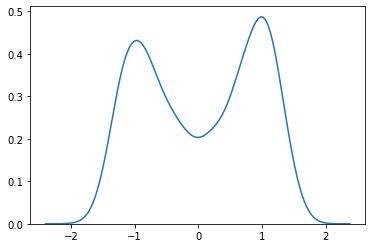

In [5]:
sns.kdeplot(np.concatenate(theta1).reshape(-1,))

## Example 2

In [6]:
mu = np.array([-5, 5]).reshape(2,1) # true value for mu
n = 200 # number of observations
y = np.r_[np.random.normal(mu[0], 1, n),np.random.normal(mu[1], 1, n)]

In [7]:
def gradU2(scale,theta,batch):
    def mn_glpdf(y,mu):
        exp1=numpy.exp(-0.5*(y-mu[0])**2)
        exp2=numpy.exp(-0.5*(y-mu[1])**2)

        v = numpy.c_[exp1*(y-mu[0]),exp2*(y-mu[1])]
        return numpy.sum(v/(exp1+exp2),axis=0)

    def mn_glpr(mu):
        return -(numpy.sum(mu)/100)
    return - scale*mn_glpdf(batch,theta)-mn_glpr(theta)

In [8]:
theta_mn = SGHMC_friction(theta0=np.array([1,1]), X = y[:,None], gradU = gradU2, eps=0.01, sample_size=1000, B=0, C=np.eye(2), batch_size=100,burnin=500)

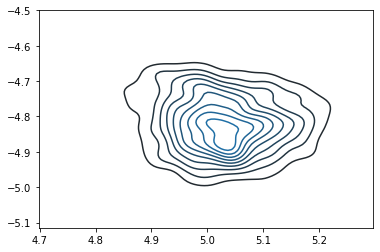

In [9]:
kdeplt2 = sns.kdeplot(theta_mn[:,0],theta_mn[:,1])  
plt.show()

## Profile Basic SGHMC function

In [10]:
profile = %prun -r -q SGHMC_friction(theta0 = np.array([0]),X = np.zeros((50,1)), gradU = gradU, eps=0.1,sample_size=2000, B=np.array([0]),C=2*np.eye(1),batch_size = 10,burnin=500)
profile.sort_stats('cumtime').print_stats(10)

          1942515 function calls (1867515 primitive calls) in 6.309 seconds

   Ordered by: cumulative time
   List reduced from 73 to 10 due to restriction <10>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    6.309    6.309 {built-in method builtins.exec}
        1    0.000    0.000    6.308    6.308 <string>:1(<module>)
        1    0.556    0.556    6.308    6.308 <ipython-input-2-e6debcd483d9>:1(SGHMC_friction)
    15000    0.643    0.000    4.175    0.000 {method 'multivariate_normal' of 'numpy.random.mtrand.RandomState' objects}
145000/70000    0.311    0.000    3.208    0.000 {built-in method numpy.core._multiarray_umath.implement_array_function}
    15000    0.040    0.000    2.117    0.000 <__array_function__ internals>:2(allclose)
    15000    0.070    0.000    2.038    0.000 numeric.py:2091(allclose)
    15000    0.036    0.000    1.702    0.000 <__array_function__ internals>:2(isclose)
    15000    0.181    0.000    1.

`np.multivariate_normal` appears to be slow

## Use SqrtM @ Normal to replace multivariate normal

In [11]:
def SGHMC_friction2(theta0, X, gradU, eps, sample_size, B, C, batch_size,burnin, M = None):
    '''
    SGHMC with friction:
    theta0(numpy array): starting position of theta
    X: data
    grad_logden_data: gradient of the data log density
    grad_logden_prior: gradient of the prior log density
    eps: step size
    sample_size: number of samples drawn from prosterior distribution
    B: noise estimate
    C: user specified friction term
    batch_size: size of minibatches
    M: Mass matrix
    '''
    
    def minib(x, batch_size):
        '''
        create minibatchs of x
        x: data
        batch_size: size of minibatch, if len(x)/batch_size is not integer, some batches wille have smaller sizes
        '''
        m = np.ceil(x.shape[0]/batch_size)
        np.random.shuffle(x)

        return np.array_split(x, m)
    
    i = sample_size+burnin
    n = theta0.shape[0]
    rt = np.zeros((i+1,n))
    thetat = np.zeros((i+1,n))
    thetat[0,:] = theta0
    batch = minib(X,batch_size)
    m = len(batch)

    if(M is None):
        M = np.eye(n)
    
    Msqrt = np.linalg.cholesky(2*eps*(C-B))
    
    for t in range(i):
        rt[t,:] = np.random.multivariate_normal(np.zeros(n), M)
        theta0,r0 = thetat[t,:],rt[t,:]
        thetai,ri = theta0.reshape(-1,1),r0.reshape(-1,1)
        for j in range(m):
            thetai = thetai + eps * np.linalg.inv(M) @ ri
            gU = gradU(X.shape[0]/batch[j].shape[0],thetai,batch[j])
            ri = ri - eps * gU.reshape(-1,1) - eps * C @ np.linalg.inv(M) @ ri + Msqrt@np.random.normal(size=n).reshape(-1,1)
        thetat[t+1,:],rt[t+1,:] = thetai.reshape(-1,n), ri.reshape(-1,n)
    
    return thetat[burnin+1:,]
        

## Test SGHMC2

In [12]:
%%time
random.seed(100)
theta1 = SGHMC_friction2(theta0 = np.array([0]),X = np.zeros((50,1)), gradU = gradU,
                eps=0.1,sample_size=10000, B=np.array([0]),C=2*np.eye(1),batch_size = 10,burnin=500)

CPU times: user 5.55 s, sys: 12 ms, total: 5.56 s
Wall time: 5.56 s


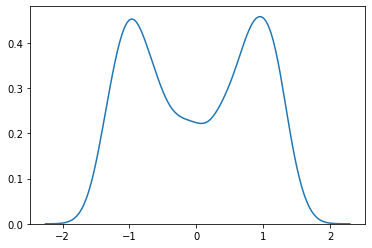

In [13]:
sns.kdeplot(theta1.reshape(-1,))

In [14]:
theta_mn = SGHMC_friction2(theta0=np.array([1,1]), X = y[:,None], gradU = gradU2, eps=0.01, sample_size=1000, B=0, C=np.eye(2), batch_size=100,burnin=500)

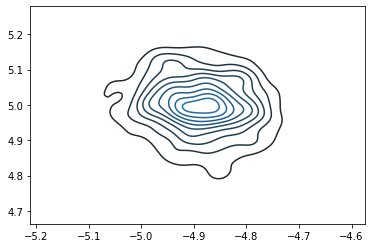

In [15]:
kdeplt2 = sns.kdeplot(theta_mn[:,0],theta_mn[:,1])  
plt.show()

## Profile SGHMC2

In [16]:
profile = %prun -r -q SGHMC_friction2(theta0 = np.array([0]),X = np.zeros((50,1)), gradU = gradU, eps=0.1,sample_size=2000, B=np.array([0]),C=2*np.eye(1),batch_size = 10,burnin=500)
profile.sort_stats('cumtime').print_stats(10)

          830095 function calls (817589 primitive calls) in 2.541 seconds

   Ordered by: cumulative time
   List reduced from 90 to 10 due to restriction <10>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    2.541    2.541 {built-in method builtins.exec}
        1    0.000    0.000    2.541    2.541 <string>:1(<module>)
        1    0.379    0.379    2.541    2.541 <ipython-input-11-a162d69d383b>:1(SGHMC_friction2)
45009/32503    0.092    0.000    1.290    0.000 {built-in method numpy.core._multiarray_umath.implement_array_function}
    25000    0.057    0.000    0.982    0.000 <__array_function__ internals>:2(inv)
    25000    0.313    0.000    0.863    0.000 linalg.py:482(inv)
     2500    0.117    0.000    0.744    0.000 {method 'multivariate_normal' of 'numpy.random.mtrand.RandomState' objects}
     2500    0.007    0.000    0.374    0.000 <__array_function__ internals>:2(allclose)
     2500    0.014    0.000    0.361    0.000

## Use parallel computation to test code

In [17]:
def SGHMC_parallel(theta0, X, gradU, eps, sample_size, B, C, batch_size,burnin, M = None):
    from ipyparallel import Client
    rc = Client()
    dv = rc[:]
    n = len(rc.ids)
    i = int((sample_size+n*burnin)/4)
    
    dv.push(dict(gradU=gradU))
    
    @dv.remote(block=True)
    def SGHMC_friction4(theta0, X, gradU, eps, i, B, C, batch_size,burnin, M = None):

        n = theta0.shape[0]
        rt = numpy.zeros((i+1,n))
        thetat = numpy.zeros((i+1,n))
        thetat[0,:] = theta0

        m1 = int(numpy.ceil(X.shape[0]/batch_size))
        batch = [X[i::m1] for i in range(m1)]
        m = len(batch)

        if(M is None):
            M = numpy.eye(n)

        Msqrt = numpy.linalg.cholesky(2*eps*(C-B))

        for t in range(i):
            rt[t,:] = numpy.random.multivariate_normal(numpy.zeros(n), M)
            theta0,r0 = thetat[t,:],rt[t,:]
            thetai,ri = theta0.reshape(-1,1),r0.reshape(-1,1)
            for j in range(m):
                thetai = thetai + eps * numpy.linalg.inv(M) @ ri
                gU = gradU(X.shape[0]/batch[j].shape[0],thetai,batch[j])
                ri = ri - eps * gU.reshape(-1,1) - eps * C @ numpy.linalg.inv(M) @ ri + (Msqrt@numpy.random.normal(size=n)).reshape(-1,1)
            thetat[t+1,:],rt[t+1,:] = thetai.reshape(-1,n), ri.reshape(-1,n)

        return thetat[burnin+1:,]
    
    theta = SGHMC_friction4(theta0, X, gradU, eps, i, B, C, batch_size,burnin, M)
    return numpy.concatenate(theta)

In [18]:
%%time
theta1 = SGHMC_parallel(np.array([0]),np.zeros((50,1)),gradU,0.1,10000, np.array([0]),2*np.eye(1),10,500)

CPU times: user 44 ms, sys: 8 ms, total: 52 ms
Wall time: 1.55 s


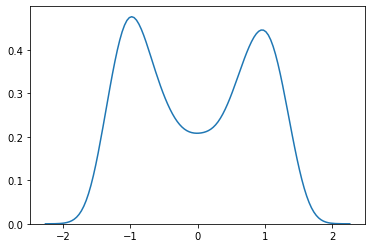

In [19]:
sns.kdeplot(np.concatenate(theta1).reshape(-1,))

In [20]:
theta_mn = SGHMC_parallel(theta0=np.array([1,1]), X = y[:,None], gradU = gradU2, eps=0.01, sample_size=1000, B=0, C=np.eye(2), batch_size=100,burnin=500)

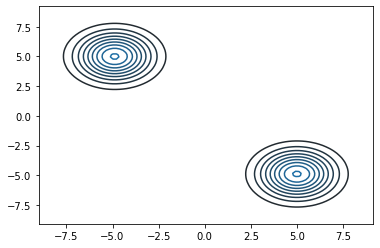

In [21]:
kdeplt2 = sns.kdeplot(theta_mn[:,0],theta_mn[:,1])  
plt.show()

In [22]:
@jit(nopython=True)
def SGHMC_numba(theta0, X, gradU, eps, sample_size, B, C, batch_size,burnin, M = None):
    '''
    SGHMC with friction. See details from Stochastic Gradient Hamiltonian Monte Carlo (Chen et al., 2014)
    
    INPUT:
    ----------------------------------------------------------------------
    theta0(numpy array of shape(p,)): starting position of theta
    
    X(numpy array of shape(n,m)): data
    
    grad_logden_data: gradient of the data log density
    
    grad_logden_prior: gradient of the prior log density
    
    eps: step size
    
    sample_size: number of samples drawn from prosterior distribution
    
    B: noise estimate
    
    C: user specified friction term
    
    batch_size: size of minibatches
    
    burnin: number of iterations for warm up
    
    M(optional): Mass matrix, defualt is set to be identity.
    ----------------------------------------------------------------------
    OUTPUT:
    
    thetat: thetas sampled from posterior distribution
    ----------------------------------------------------------------------
    '''
    

    
    i = sample_size+burnin
    p = theta0.shape[0]
    rt = np.zeros((i+1,p))
    thetat = np.zeros((i+1,p))
    thetat[0,:] = theta0
    
    m1 = int(numpy.ceil(X.shape[0]/batch_size))
    batch = [X[i::m1] for i in range(m1)]
    m = len(batch)

    if(M is None):
        M = np.eye(p)
    
    for t in range(i):
        rt[t,:] = np.random.multivariate_normal(np.zeros(p), M)
        theta0,r0 = thetat[t,:],rt[t,:]
        thetai,ri = theta0.reshape(-1,1),r0.reshape(-1,1)
        for j in range(m):
            thetai = thetai + eps * np.linalg.inv(M) @ ri
            gU = gradU(X.shape[0]/batch[j].shape[0],thetai,batch[j])
            ri = ri - eps * gU.reshape(-1,1) - eps * C @ np.linalg.inv(M) @ ri + np.random.multivariate_normal(np.zeros(p), np.array(2*eps*(C-B)).reshape(p,p)).reshape(-1,1)
        thetat[t+1,:],rt[t+1,:] = thetai.reshape(-1,p), ri.reshape(-1,p)

    return thetat[burnin+1:,]

## figure 1 real distribution

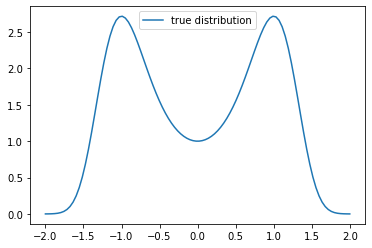

In [23]:
theta = np.linspace(-2,2,100)
p = np.exp(2*theta**2-theta**4)
fig, ax = plt.subplots()
ax.plot(theta,p,label = "true distribution")
ax.legend(loc= "upper center")